In [1]:
import bambi as bmb
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import arviz as az

In [2]:
# Read prepared data from BES RPS 
train = pd.read_csv("BES cleaned.csv")
print(train.shape)

(2657, 8)


In [3]:
# Define and fit turnout model
model_hierarchical = bmb.Model("TO ~ 1 + C(SexCat) + C(AgeCat) + C(ONSed) + C(Region) + (1|C(ONSConstID))", train, family="bernoulli")

In [4]:
TO_model = model_hierarchical.fit(draws=100, 
    tune=1000, 
    chains=4, 
    random_seed=42)

Modeling the probability that TO==1
C:\Users\roddy\anaconda3\envs\MRP_map\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, C(SexCat), C(AgeCat), C(ONSed), C(Region), 1|C(ONSConstID)_sigma, 1|C(ONSConstID)_offset]


Output()

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [5]:
# Read ONS data to predict turnout for each poststratification cell
ONS_df = pd.read_csv("ONS cleaned.csv")
predict_df = ONS_df[['AgeCat', 'SexCat', 'ONSed','Region','ONSConstID']].drop_duplicates()

In [6]:
# predict on poststratification frame
model_hierarchical.predict(TO_model, data=predict_df, sample_new_groups=True)

In [7]:
# calculate mean from posterior probability sample, with hdi lower and upper estimates  
TO_mean = TO_model['posterior']['p'].mean(dim=['chain', 'draw'])
TO_hdi = az.hdi(TO_model, hdi_prob=0.95)
TO_lower = TO_hdi['p'].sel(hdi='lower')
TO_upper = TO_hdi['p'].sel(hdi='higher')

In [8]:
# add mean probability of turnout to poststratification frame
predict_df['TO'] = TO_mean
predict_df['TO_upper95'] = TO_upper
predict_df['TO_lower95'] = TO_lower

In [9]:
ONS_with_TO = pd.merge(ONS_df, predict_df, on=['AgeCat','SexCat', 'ONSed', 'Region', 'ONSConstID']).drop(columns=['Unnamed: 0'])

In [10]:
# calculate turnout from predicted probabilities and ONS census population for each cell (with upper and lower 95% HDI estimate)
ONS_with_TO['TO N'] = ONS_with_TO['TO']*ONS_with_TO['Observation']
ONS_with_TO['TO N upper95'] = ONS_with_TO['TO_upper95']*ONS_with_TO['Observation']
ONS_with_TO['TO N lower95'] = ONS_with_TO['TO_lower95']*ONS_with_TO['Observation']

# estimate total turnout
turnout_est = ONS_with_TO['TO N'].sum()/ONS_with_TO['Observation'].sum()
turnout_est_top = ONS_with_TO['TO N upper95'].sum()/ONS_with_TO['Observation'].sum()
turnout_est_low = ONS_with_TO['TO N lower95'].sum()/ONS_with_TO['Observation'].sum()

In [11]:
print(f"Turnout estimate: {100*turnout_est:.1f}% ({100*turnout_est_low:.1f}%-{100*turnout_est_top:.1f}%)\nActual turnout: 59.7%")

Turnout estimate: 68.0% (52.2%-83.0%)
Actual turnout: 59.7%


In [12]:
ONS_with_TO.to_csv('ONS with turnout prediction.csv')

C:\Users\roddy\anaconda3\envs\MRP_map\Lib\site-packages\arviz\plots\traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (41697), generating only 20 plots
  warnings.warn(


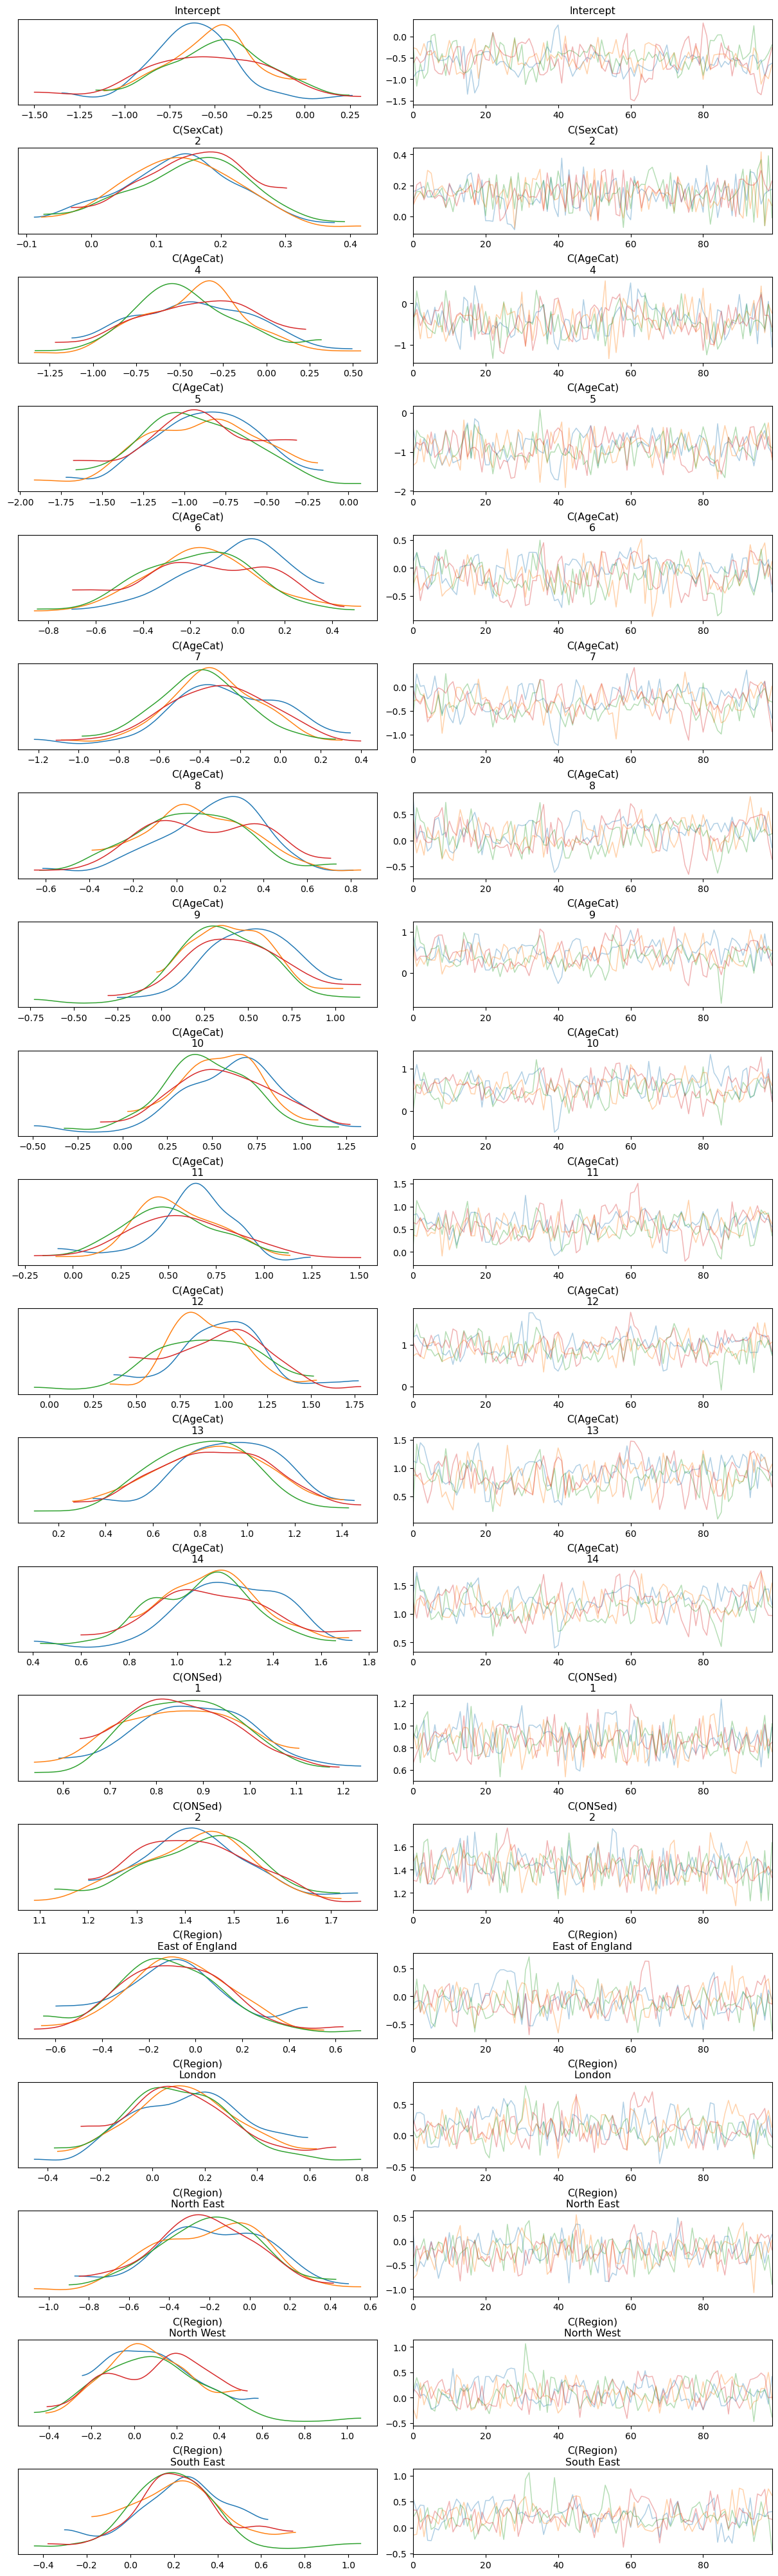

In [13]:
trace_plots = az.plot_trace(TO_model, compact=False, backend_kwargs={"layout": "constrained"})

In [ ]:
model_summary = az.summary(TO_model)

In [ ]:
print(f"""Max r_hat: {model_summary['r_hat'].max()}\nMin r_hat: {model_summary['r_hat'].min()}""")